Direktori 'trained_model_FIXED_RF_MeanStd_CV_Tuned_6400rows_v2' berhasil dibuat.
--- Fase 1: Langkah 1 (Memuat Data YANG SUDAH DIPERBAIKI dan DIPERBANYAK) ---
Dataset 'data_sensor_rgb_nominal_FIXED.csv' berhasil dimuat. Jumlah baris mentah: 12400

--- Fase 1: Langkah 2 (Inspeksi Data Asli) ---
              Merah         Hijau          Biru
count  12400.000000  12400.000000  12400.000000
mean    3332.469355  14180.179677   1728.077177
std     1610.187457   8177.460214    857.104274
min     2394.000000   9418.000000   1223.000000
25%     2618.750000  10801.000000   1362.000000
50%     2836.000000  11509.000000   1451.000000
75%     3136.000000  12547.250000   1621.250000
max     9231.000000  43522.000000   4847.000000

INFO: Semua nilai Hijau dalam dataset adalah positif.

--- Fase Iterasi: Rekayasa Fitur Menggunakan HSV (Mean dan Std) ---

Nilai maksimum RGB disimpan di 'trained_model_FIXED_RF_MeanStd_CV_Tuned_6400rows_v2\max_rgb_values_FIXED_CV_Tuned_6400rows_v2.joblib'

Melakukan agr

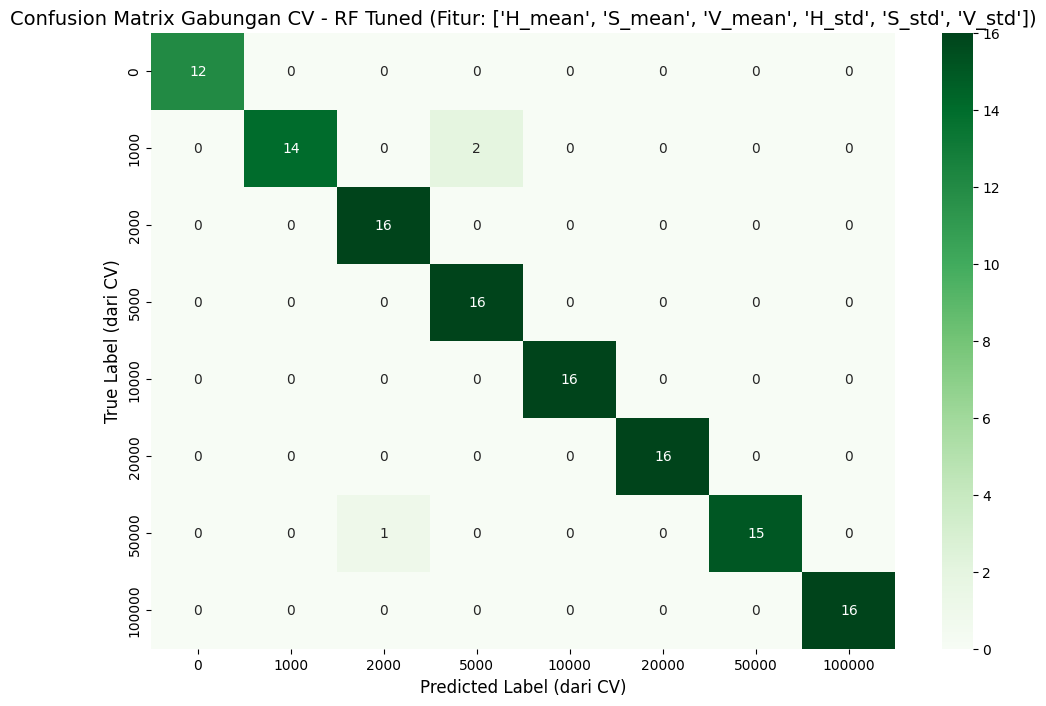

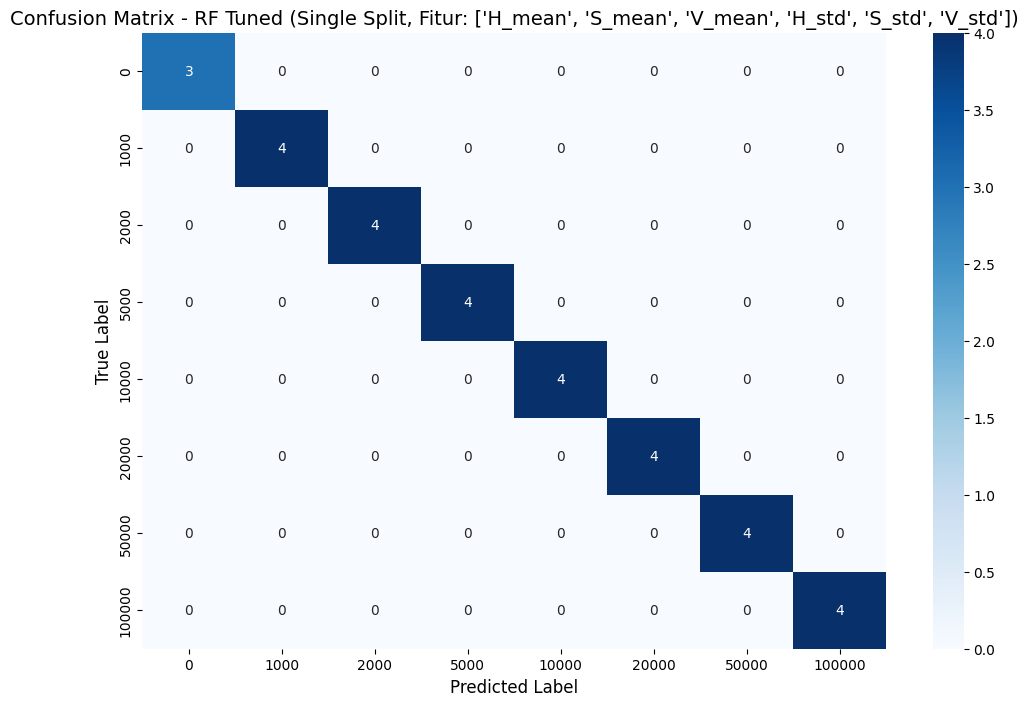

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import colorsys
import os
import numpy as np

# --- Variabel Global untuk Path Penyimpanan ---
MODEL_DIR = "trained_model_FIXED_RF_MeanStd_CV_Tuned_6400rows_v2" 
MODEL_PATH = os.path.join(MODEL_DIR, "rf_model_MeanStdHSV_CV_Tuned_6400rows_v2.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_MeanStdHSV_CV_Tuned_6400rows_v2.joblib") 
MAX_RGB_PATH = os.path.join(MODEL_DIR, "max_rgb_values_FIXED_CV_Tuned_6400rows_v2.joblib")
# Path untuk confusion matrix
CM_CV_COMBINED_PATH = os.path.join(MODEL_DIR, "confusion_matrix_RF_MeanStd_CV_combined_6400rows_v2.png")
CM_SINGLE_SPLIT_PATH = os.path.join(MODEL_DIR, "confusion_matrix_RF_MeanStd_single_split_6400rows_v2.png")


def train_and_save_rf_mean_std_cv_tuned_6400rows_v2():
    """
    Fungsi utama untuk memuat data terbaru, melatih model RandomForest 
    (dengan fitur Mean & Std H,S,V) menggunakan GridSearchCV dan validasi silang, 
    lalu menyimpan artefak dan membuat CM.
    """
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
        print(f"Direktori '{MODEL_DIR}' berhasil dibuat.")

    print("--- Fase 1: Langkah 1 (Memuat Data YANG SUDAH DIPERBAIKI dan DIPERBANYAK) ---")
    # Menggunakan file CSV yang baru diunggah oleh pengguna
    file_path = 'data_sensor_rgb_nominal_FIXED.csv' 
    df_original = pd.DataFrame()
    try:
        df_original = pd.read_csv(file_path)
        print(f"Dataset '{file_path}' berhasil dimuat. Jumlah baris mentah: {len(df_original)}")
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan.")
        return 

    if df_original.empty:
        print("DataFrame asli kosong. Proses dihentikan.")
        return

    print("\n--- Fase 1: Langkah 2 (Inspeksi Data Asli) ---")
    print(df_original[['Merah', 'Hijau', 'Biru']].describe())
    if (df_original['Hijau'] < 0).any():
        print("\nPERINGATAN: Masih ada nilai Hijau negatif! Periksa kembali data sumber.")
        # return # Sebaiknya dihentikan jika masih ada masalah data
    else:
        print("\nINFO: Semua nilai Hijau dalam dataset adalah positif.")

    print("\n--- Fase Iterasi: Rekayasa Fitur Menggunakan HSV (Mean dan Std) ---")
    df_temp = df_original.copy()

    max_r = df_temp['Merah'].max()
    max_g = df_temp['Hijau'].max()
    max_b = df_temp['Biru'].max()
    max_rgb_values = {'max_r': max_r, 'max_g': max_g, 'max_b': max_b}
    joblib.dump(max_rgb_values, MAX_RGB_PATH)
    print(f"\nNilai maksimum RGB disimpan di '{MAX_RGB_PATH}'")

    df_temp['R_norm'] = df_temp['Merah'] / max_r
    df_temp['G_norm'] = df_temp['Hijau'] / max_g
    df_temp['B_norm'] = df_temp['Biru'] / max_b
    df_temp[['R_norm', 'G_norm', 'B_norm']] = df_temp[['R_norm', 'G_norm', 'B_norm']].clip(0, 1)

    def rgb_to_hsv_row(row):
        r, g, b = row['R_norm'], row['G_norm'], row['B_norm']
        h_val, s_val, v_val = colorsys.rgb_to_hsv(r, g, b)
        return pd.Series({'H': h_val, 'S': s_val, 'V': v_val})

    hsv_features_individual = df_temp.apply(rgb_to_hsv_row, axis=1)
    df_temp = pd.concat([df_temp, hsv_features_individual], axis=1)
    
    print("\nMelakukan agregasi fitur H, S, V (Mean dan Std) per Nominal dan Posisi...")
    agg_functions = {'H': ['mean', 'std'], 'S': ['mean', 'std'], 'V': ['mean', 'std']}
    df_processed_agg = df_temp.groupby(['Nominal', 'Posisi']).agg(agg_functions).reset_index()

    # Meratakan nama kolom hasil agregasi
    new_columns = []
    for col in df_processed_agg.columns.values:
        if isinstance(col, tuple):
            if col[1]: # Jika ada nama fungsi agregasi (seperti 'mean', 'std')
                new_columns.append(f"{col[0]}_{col[1]}")
            else: # Jika hanya nama kolom asli (seperti 'Nominal', 'Posisi' setelah reset_index)
                new_columns.append(col[0])
        else:
            new_columns.append(col)
    df_processed_agg.columns = new_columns
    
    print("Data setelah agregasi fitur (Mean & Std HSV):")
    print(df_processed_agg.head())
    print(f"Jumlah sampel unik setelah agregasi: {len(df_processed_agg)}")
    
    X_features, y_target = pd.DataFrame(), pd.Series() 
    if not df_processed_agg.empty:
        feature_columns = ['H_mean', 'S_mean', 'V_mean', 'H_std', 'S_std', 'V_std'] 
        if all(col in df_processed_agg.columns for col in feature_columns + ['Nominal']):
            X_features = df_processed_agg[feature_columns] 
            y_target = df_processed_agg['Nominal'] 
            print(f"\nFitur (X_features) dan Target (y_target) dibentuk. Fitur yang digunakan: {feature_columns}")
            print(f"Bentuk X_features: {X_features.shape}")
            print(f"Jumlah kelas unik dalam target (y_target): {y_target.nunique()}")
        else:
            print(f"Kolom yang dibutuhkan ({feature_columns} + ['Nominal']) tidak ada di df_processed_agg. Kolom yang ada: {df_processed_agg.columns}")
            return
    else:
        print("df_processed_agg kosong. Proses dihentikan.")
        return
    
    X_features = X_features.fillna(0)
    print("\nNilai NaN pada fitur standar deviasi (jika ada) telah diisi dengan 0.")

    scaler_global = MinMaxScaler()
    X_scaled_global_array = scaler_global.fit_transform(X_features)
    X_scaled_global_df = pd.DataFrame(X_scaled_global_array, columns=feature_columns)
    joblib.dump(scaler_global, SCALER_PATH) 
    print(f"\nScaler global di-fit pada X_features ({feature_columns}) dan disimpan di '{SCALER_PATH}'.")

    param_grid_rf = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 5, 7, 10, 15],
        'min_samples_split': [2, 4, 6, 8],
        'min_samples_leaf': [1, 2, 3, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    
    n_splits_gridsearch = 4 
    # Hitung jumlah sampel per kelas dari y_target (setelah agregasi)
    samples_per_class_for_grid = y_target.value_counts()
    min_samples_per_class_gridsearch = samples_per_class_for_grid.min()

    if min_samples_per_class_gridsearch < n_splits_gridsearch :
         n_splits_gridsearch = max(2, min_samples_per_class_gridsearch) # Pastikan minimal 2
         print(f"Menyesuaikan n_splits untuk GridSearchCV menjadi: {n_splits_gridsearch}")
    
    rf_for_grid = RandomForestClassifier(random_state=42)
    print(f"\n--- Memulai GridSearchCV untuk RandomForest (Fitur: {feature_columns}) ---")
    grid_search_rf = GridSearchCV(estimator=rf_for_grid, param_grid=param_grid_rf, 
                                  cv=StratifiedKFold(n_splits=n_splits_gridsearch, shuffle=True, random_state=42), 
                                  scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search_rf.fit(X_scaled_global_df, y_target) 
    
    best_params_rf = grid_search_rf.best_params_
    print(f"\n--- GridSearchCV untuk RandomForest Selesai ---")
    print(f"Parameter terbaik yang ditemukan: {best_params_rf}")
    print(f"Skor akurasi terbaik dari GridSearchCV: {grid_search_rf.best_score_:.4f}")

    n_splits_eval = 4 
    samples_per_class_for_eval = y_target.value_counts()
    min_samples_per_class_eval = samples_per_class_for_eval.min()
    
    can_cv = False
    if min_samples_per_class_eval < 2 : 
        print("Error: Tidak cukup sampel per kelas untuk StratifiedKFold (perlu minimal 2). Tidak bisa melakukan evaluasi CV.")
    elif len(df_processed_agg) < n_splits_eval or y_target.nunique() > len(df_processed_agg)/n_splits_eval :
        n_splits_eval = max(2, min_samples_per_class_eval) # Sesuaikan n_splits_eval
        print(f"Menggunakan n_splits yang disesuaikan untuk evaluasi CV: {n_splits_eval}")
        if n_splits_eval >= 2: can_cv = True
    else:
        if n_splits_eval >=2: can_cv = True # n_splits_eval default (4) sudah oke
    
    all_y_test_fold_cv = []
    all_y_pred_fold_cv = []

    if can_cv:
        skf_eval = StratifiedKFold(n_splits=n_splits_eval, shuffle=True, random_state=42)
        fold_accuracies_rf_tuned = []
        print(f"\n--- Memulai Validasi Silang dengan RandomForest (Tuned, Fitur: {feature_columns}) menggunakan {n_splits_eval} Fold ---")
        for fold, (train_index, test_index) in enumerate(skf_eval.split(X_scaled_global_df, y_target)):
            print(f"\nFold {fold+1}/{n_splits_eval}")
            X_train_fold_cv, X_test_fold_cv = X_scaled_global_df.iloc[train_index], X_scaled_global_df.iloc[test_index]
            y_train_fold_cv, y_test_fold_cv = y_target.iloc[train_index], y_target.iloc[test_index]
            
            model_fold = RandomForestClassifier(**best_params_rf, random_state=42) 
            model_fold.fit(X_train_fold_cv, y_train_fold_cv)
            
            y_pred_fold_cv = model_fold.predict(X_test_fold_cv)
            accuracy_fold = accuracy_score(y_test_fold_cv, y_pred_fold_cv)
            fold_accuracies_rf_tuned.append(accuracy_fold)
            print(f"  Akurasi Fold {fold+1}: {accuracy_fold:.4f}")

            all_y_test_fold_cv.extend(y_test_fold_cv)
            all_y_pred_fold_cv.extend(y_pred_fold_cv)

        print(f"\n--- Hasil Validasi Silang RandomForest (Tuned, Fitur: {feature_columns}) ---")
        print(f"Akurasi per fold: {fold_accuracies_rf_tuned}")
        print(f"Rata-rata Akurasi CV RandomForest (Tuned): {np.mean(fold_accuracies_rf_tuned):.4f} (+/- {np.std(fold_accuracies_rf_tuned):.4f})")

        if all_y_test_fold_cv: 
            print("\n--- Membuat Confusion Matrix Gabungan dari Hasil Validasi Silang ---")
            unique_labels_cv_combined = sorted(y_target.unique())
            cm_cv_combined = confusion_matrix(all_y_test_fold_cv, all_y_pred_fold_cv, labels=unique_labels_cv_combined)
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(cm_cv_combined, annot=True, fmt='d', cmap='Greens', 
                        xticklabels=unique_labels_cv_combined, yticklabels=unique_labels_cv_combined)
            plt.xlabel('Predicted Label (dari CV)', fontsize=12)
            plt.ylabel('True Label (dari CV)', fontsize=12)
            plt.title(f'Confusion Matrix Gabungan CV - RF Tuned (Fitur: {feature_columns})', fontsize=14)
            plt.savefig(CM_CV_COMBINED_PATH)
            print(f"Confusion matrix gabungan dari CV disimpan di '{CM_CV_COMBINED_PATH}'. Harap periksa plot ini.")
    else:
        print("\nTidak dapat melakukan validasi silang.")

    print(f"\n--- Melatih Model RandomForest Final (Tuned, Fitur: {feature_columns}) pada Keseluruhan Data Agregasi ---")
    final_model = RandomForestClassifier(**best_params_rf, random_state=42) 
    final_model.fit(X_scaled_global_df, y_target) 
    joblib.dump(final_model, MODEL_PATH)
    print(f"Model RandomForest final (tuned) berhasil dilatih dan disimpan di '{MODEL_PATH}'.")
    
    print("\n--- Membuat Confusion Matrix dari Single Train/Test Split untuk Analisis Kesalahan (menggunakan Model Final) ---")
    # Pastikan ada cukup sampel untuk split ini juga, dan jumlah kelas terwakili
    # Untuk 64 sampel, 8 kelas, test_size=0.25 -> 16 sampel tes (2 per kelas)
    test_size_cm = 0.25 
    if X_scaled_global_df.shape[0] * test_size_cm < y_target.nunique():
        print("Peringatan: test_size untuk CM mungkin terlalu kecil untuk stratifikasi yang valid.")
        # Coba naikkan test_size jika perlu, atau terima potensi ketidakseimbangan
        # Untuk contoh ini, kita biarkan 0.25

    X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(
        X_scaled_global_df, y_target, test_size=test_size_cm, random_state=123, stratify=y_target 
    )
    
    if X_test_cm.empty:
        print("Set tes untuk CM kosong, tidak bisa membuat confusion matrix.")
    else:
        y_pred_cm = final_model.predict(X_test_cm)
        accuracy_cm_split = accuracy_score(y_test_cm, y_pred_cm)
        print(f"Akurasi pada split tunggal untuk CM: {accuracy_cm_split:.4f} (Jumlah sampel tes: {len(y_test_cm)})")
        
        unique_labels_cm = sorted(y_target.unique())
        cm_single = confusion_matrix(y_test_cm, y_pred_cm, labels=unique_labels_cm)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm_single, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=unique_labels_cm, yticklabels=unique_labels_cm)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title(f'Confusion Matrix - RF Tuned (Single Split, Fitur: {feature_columns})', fontsize=14)
        plt.savefig(CM_SINGLE_SPLIT_PATH)
        print(f"Confusion matrix dari single split disimpan di '{CM_SINGLE_SPLIT_PATH}'. Harap periksa plot ini.")

    print(f"\n--- Pelatihan dengan RandomForest (Tuned, Fitur: {feature_columns}), Validasi Silang, dan Analisis CM Selesai ---")

if __name__ == "__main__":
    train_and_save_rf_mean_std_cv_tuned_6400rows_v2()
